In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, DotProduct, ConstantKernel as C
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt

# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the data
fatigue_df = pd.read_csv('../Data/Carbon_Torsion_PI.csv')
fatigue_df

,Heat,Stress (Mpa),Number of Cycles,Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,Reduction of Area,C,Si,Mn,P,S,Ni,Cr,Cu,PI Fatigue Life
0,1,320,28100,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02,3.321334e+04
1,1,320,32100,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02,3.321334e+04
2,1,310,90400,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02,6.773490e+04
3,1,310,119000,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02,6.773490e+04
4,1,300,263000,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02,1.413961e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,36,320,88300,650,660,0.06,0.00,0.0,33,23,62,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,3.969058e+04
374,36,310,117000,650,660,0.06,0.00,0.0,33,23,62,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,9.258966e+04
375,36,300,144000,650,660,0.06,0.00,0.0,33,23,62,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,2.220432e+05
376,36,300,321000,650,660,0.06,0.00,0.0,33,23,62,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,2.220432e+05


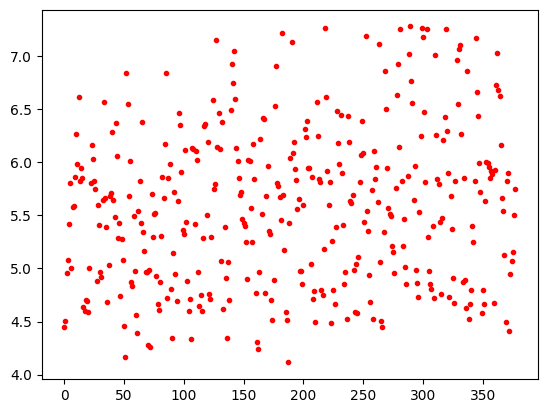

In [ ]:
# Scatter Plot
plt.plot(np.log10(fatigue_df['Number of Cycles']), 'r.')

# Sort the data by ascending order of number of cycles
fatigue_df.sort_values(by=['Number of Cycles'], ascending=True, ignore_index=True, inplace=True)

In [ ]:
# Remove columns that are not needed
drop_cols = ['Heat','Number of Cycles'] # list the columns to drop along with target for independent feautures

# Use all remaining columns as features
features = fatigue_df.drop(drop_cols, axis=1)

# Use log transform of the number of cycles as targets
targets = np.log10(fatigue_df['Number of Cycles'])

# Display the features
features

,Stress (Mpa),Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,Reduction of Area,C,Si,Mn,P,S,Ni,Cr,Cu,PI Fatigue Life
0,360,550,825,0.10,0.03,0.01,33,22,63,0.44,0.24,0.82,0.021,0.021,0.03,0.02,0.02,1.615986e+04
1,320,550,610,0.07,0.00,0.03,33,21,62,0.26,0.23,0.51,0.018,0.024,0.01,0.02,0.01,8.962672e+03
2,350,550,1270,0.12,0.01,0.00,33,22,66,0.45,0.26,0.76,0.027,0.019,0.01,0.11,0.02,1.778024e+04
3,290,600,1270,0.07,0.02,0.00,33,27,72,0.25,0.18,0.44,0.009,0.017,0.08,0.12,0.08,7.521639e+03
4,280,600,1270,0.07,0.02,0.00,33,27,72,0.25,0.18,0.44,0.009,0.017,0.08,0.12,0.08,3.701477e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,360,550,660,0.06,0.00,0.00,33,55,79,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,9.787854e+06
374,310,600,1270,0.08,0.01,0.00,33,22,60,0.54,0.26,0.76,0.022,0.021,0.02,0.12,0.01,6.547304e+06
375,290,600,825,0.10,0.03,0.01,33,25,66,0.44,0.24,0.82,0.021,0.021,0.03,0.02,0.02,8.935626e+06
376,350,550,660,0.06,0.00,0.00,33,55,79,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,4.144169e+07


In [ ]:
# Convert the features into floats
features = features.astype('float64')

In [ ]:
# Calculate the coverage percentage of values within a specified range
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

Run # 1 Fold # 1


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Pearson CC: 0.8047579147392021
R2 score: 0.6472187803322398
RMSE: 0.4188709912302258
MAE: 0.32662302772150675
Coverage: 92.10526315789473
Upper coverage: 97.36842105263156
Lower coverage: 94.73684210526315
Pearson R2 median: 0.8047579147392021
R2 median: 0.6472187803322398
RMSE median: 0.4188709912302258
Average Interval Width: 1.7517920801791593
Median Interval Width: 1.7378498971883296
Composite Metric: 0.8346453961113863


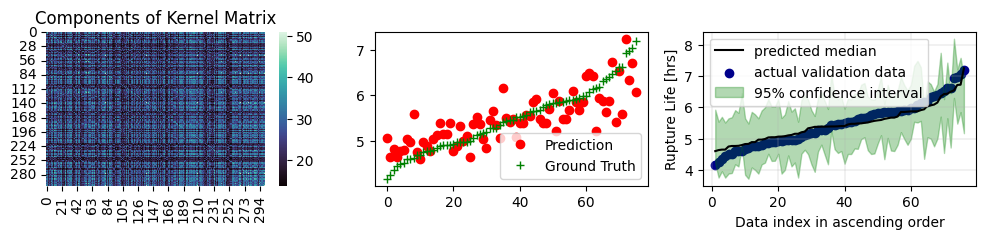

********************
Run # 1 Fold # 2
Pearson CC: 0.8152213527697277
R2 score: 0.653357506957188
RMSE: 0.41353368006785
MAE: 0.3312878363119463
Coverage: 98.68421052631578
Upper coverage: 99.99999999999999
Lower coverage: 98.68421052631578
Pearson R2 median: 0.8152213527697277
R2 median: 0.653357506957188
RMSE median: 0.41353368006785
Average Interval Width: 1.8003970041727797
Median Interval Width: 1.7852935253989015
Composite Metric: 0.8801645743306573


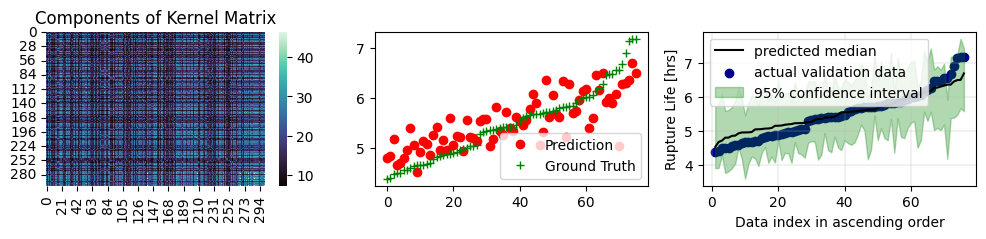

********************
Run # 1 Fold # 3
Pearson CC: 0.7819516512425825
R2 score: 0.562761250929271
RMSE: 0.45953464843403913
MAE: 0.3498572871606925
Coverage: 94.73684210526315
Upper coverage: 99.99999999999999
Lower coverage: 94.73684210526315
Pearson R2 median: 0.7819516512425825
R2 median: 0.562761250929271
RMSE median: 0.45953464843403913
Average Interval Width: 1.7554003102625388
Median Interval Width: 1.7168835470117596
Composite Metric: 0.8561389873274622


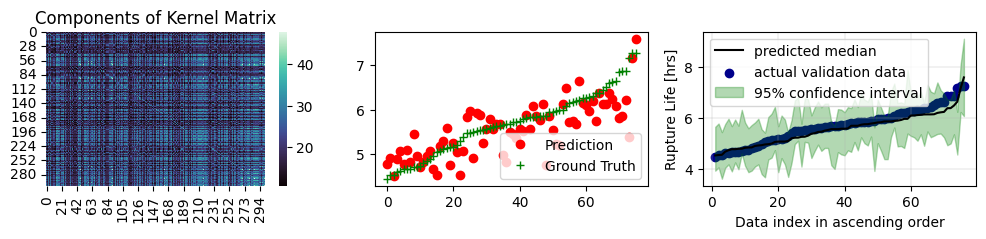

********************
Run # 1 Fold # 4
Pearson CC: 0.8292818915891196
R2 score: 0.6722447808138282
RMSE: 0.4846300145742096
MAE: 0.39296722580896887
Coverage: 94.66666666666666
Upper coverage: 98.66666666666664
Lower coverage: 95.99999999999999
Pearson R2 median: 0.8292818915891196
R2 median: 0.6722447808138282
RMSE median: 0.4846300145742096
Average Interval Width: 1.7647468544335698
Median Interval Width: 1.7393456560889256
Composite Metric: 0.8537322128151039


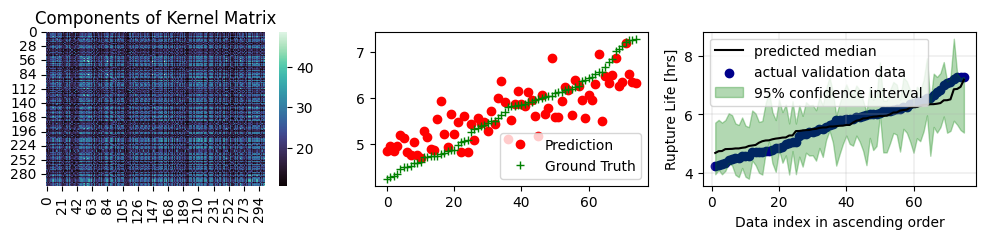

********************
Run # 1 Fold # 5


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Pearson CC: 0.8477205057420881
R2 score: 0.7010240019643255
RMSE: 0.39232718864388766
MAE: 0.31993739802387194
Coverage: 98.66666666666664
Upper coverage: 99.99999999999999
Lower coverage: 98.66666666666664
Pearson R2 median: 0.8477205057420881
R2 median: 0.7010240019643255
RMSE median: 0.39232718864388766
Average Interval Width: 1.8361317538671096
Median Interval Width: 1.7931320163752797
Composite Metric: 0.8794208556408253


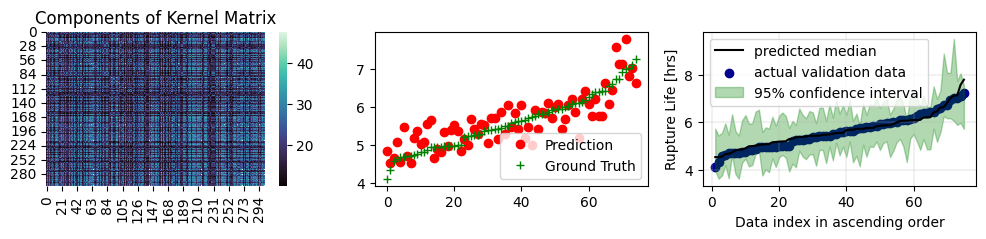

********************


In [ ]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
MAPE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
upper_coverage = np.zeros_like(PearsonCC)
lower_coverage = np.zeros_like(PearsonCC)
mean_interval_width = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=50+j)
        kernel = C(1.0) * Matern(length_scale=1.0) + WhiteKernel(noise_level=1.0) + C(1.0) * DotProduct(sigma_0=1.0)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            X_train, X_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = MinMaxScaler()
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)

            model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=8, normalize_y=True)
            model.fit(X_train, y_train)

            mu_z, std_z = model.predict(X_test, return_std=True)
            y_pred_test = mu_z
            y_pred_unc_test = std_z

            PearsonCC[j, i] = pearsonr(y_test, y_pred_test)[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-y_test))

            df_test_low = y_pred_test - 2 * y_pred_unc_test
            df_test_median = y_pred_test
            df_test_high = y_pred_test + 2 * y_pred_unc_test

            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)
            upper_coverage[j, i] = coverage(y_test, df_test_low, np.inf)
            lower_coverage[j, i] = coverage(y_test, -np.inf, df_test_high)

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')
            print(f'Coverage: {test_coverage[j, i]}')
            print(f'Upper coverage: {upper_coverage[j, i]}')
            print(f'Lower coverage: {lower_coverage[j, i]}')

            print(f"Pearson R2 median: {pearsonr(y_test, df_test_median)[0]}")
            print(f"R2 median: {r2_score(y_test, df_test_median)}")
            print(f"RMSE median: {np.sqrt(mean_squared_error(y_test, df_test_median))}")

            # Prediction interval width
            # Quantifies the average width of the prediction intervals. Smaller widths suggest more precise uncertainty estimates.
            mean_interval_width[j, i] = np.mean(df_test_high - df_test_low)
            print(f'Average Interval Width: {mean_interval_width[j, i]}')
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Median Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            plt.figure(figsize=(12,2))
            plt.subplot(131)
            K = model.kernel_(model.X_train_)
            K[np.diag_indices_from(K)] += model.alpha
            sns.heatmap(K, cmap='mako')
            plt.title('Components of Kernel Matrix')
            plt.subplot(132)
            plt.plot(y_pred_test, 'ro', label='Prediction')
            plt.plot(np.array(y_test), 'g+', label='Ground Truth')
            plt.legend(loc=4)
            plt.subplot(133)
            plt.plot(np.arange(1, len(y_test)+1), sorted(df_test_median),
                     label='predicted median', color='k')
            plt.scatter(np.arange(1, len(y_test)+1), y_test,
                         marker='o', color='darkblue', label='actual validation data')
            plt.fill_between(np.arange(1, len(y_test)+1), df_test_low,
                             df_test_high, alpha=0.3,
                           color='green', label='95% confidence interval')
            plt.grid(True, which='major', linestyle='-', linewidth='0.25')#, color='gray')
            plt.ylabel('Rupture Life [hrs]')
            plt.xlabel('Data index in ascending order')
            plt.ticklabel_format(style='sci', scilimits=(-3,4), axis='y')
            plt.legend()
            plt.show()

            print(20*'*')

In [ ]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'Coverage': test_coverage.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,Coverage
0,0.804758,0.647219,0.418871,0.326623,92.105263
1,0.815221,0.653358,0.413534,0.331288,98.684211
2,0.781952,0.562761,0.459535,0.349857,94.736842
3,0.829282,0.672245,0.484630,0.392967,94.666667
4,0.847721,0.701024,0.392327,0.319937,98.666667


In [ ]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
test_coverage_mean = np.mean(test_coverage)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
test_coverage_std = np.std(test_coverage)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std, 'Test Coverage Mean': test_coverage_mean, 'Test Coverage Std':test_coverage_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,Test Coverage Mean,Test Coverage Std
0,0.815787,0.02222,0.647321,0.046243,0.433779,0.033465,0.344135,0.026361,95.77193,2.553364


In [ ]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(), 'Upper Coverage': upper_coverage.flatten(), 'Lower Coverage': lower_coverage.flatten(),
                    'Mean Interval Width': mean_interval_width.flatten(), 'Median Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Upper Coverage,Lower Coverage,Mean Interval Width,Median Interval Width,Composite Metric
0,92.105263,97.368421,94.736842,1.751792,1.737850,0.834645
1,98.684211,100.000000,98.684211,1.800397,1.785294,0.880165
2,94.736842,100.000000,94.736842,1.755400,1.716884,0.856139
3,94.666667,98.666667,96.000000,1.764747,1.739346,0.853732
4,98.666667,100.000000,98.666667,1.836132,1.793132,0.879421


In [ ]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
upper_coverage_mean = np.mean(upper_coverage)
lower_coverage_mean = np.mean(lower_coverage)
mean_interval_width_mean = np.mean(mean_interval_width)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
upper_coverage_std = np.std(upper_coverage)
lower_coverage_std = np.std(lower_coverage)
mean_interval_width_std = np.std(mean_interval_width)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std, 'Upper Coverage Mean': upper_coverage_mean, 'Upper Coverage Std': upper_coverage_std,
                  'Lower Coverage Mean': lower_coverage_mean, 'Lower Coverage Std': lower_coverage_std,
                    'Mean Interval Width Mean': mean_interval_width_mean, 'Mean Interval Width Std':mean_interval_width_std,
                    'Median Interval Width Mean': median_interval_width_mean, 'Median Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Upper Coverage Mean,Upper Coverage Std,Lower Coverage Mean,Lower Coverage Std,Mean Interval Width Mean,Mean Interval Width Std,Median Interval Width Mean,Median Interval Width Std,Composite Metric Mean,Composite Metric Std
0,95.77193,2.553364,99.207018,1.054408,96.564912,1.783906,1.781694,0.032205,1.754501,0.029538,0.86082,0.01719
